# Thermal stability of hundreds of point mutants of a family 1 glycoside hydrolase 

Here, we are determining the thermal stability of about a hundred and fifty point mutants of BglB (model based on 2JIE). After automated mutagensis of the BglB coding sequence, protein production, and protein purification, each mutant's activity at 100 mM pNPG at pH 7.4 at a range of temperatures from 30 C to 50 C was measured using the rate of formation of the pNPG hydrolysis product p-nitrophenol. 

Data were collected into a table with the columns `well`, `rate`, and `mutant` using Google Docs and exported to CSV, which is the input file here. 

## Data input and cleanup 

In [28]:
%matplotlib inline
import matplotlib.pyplot as plt
import pandas
from scipy.optimize import curve_fit 
from numpy import log, exp, linspace, sqrt, diag
from sklearn.linear_model import LinearRegression
import os
import re 

df = pandas.read_csv( 'data/Bagel Thermostability - Thermostability assay data.csv' )
raw = len( df )
df.index = df.mutant
df.drop( 'mutant', inplace=True )
df.drop( ['WT', 'WT1'], inplace=True )
df.dropna( inplace=True ) 

with open( 'data/allowed_mutants.txt' ) as fn:
    mutants = [ i.split('.')[0].upper() for i in fn.readlines() if len( i ) > 1 ]
    
def is_good( name ):
    return name in mutants 

# this is a sanity-checking routine for "off-by-threes"
# let's just rename all the tubes
not_allowed = []
l = []
for name in df.index:
    #print name
    if is_good( name ):
        l.append( name )
    else:
        new = name[0] + str( int( re.findall( r'\d+', name )[0] ) - 3 ) + name[-1]
        if is_good( new ):
            l.append( new )
        else:
            l.append( 'drop_me' )
            not_allowed.append( name )
            
assert len( df.index ) == len( l ) # do not want to reindex wrongly! 
df.index = l
df.drop( ['drop_me'], inplace=True )

# temperature keys as CSV files in data/
temp_key = pandas.read_csv( 'data/temp_key.csv' )
temp_key.index = temp_key.Well
df['temp'] = df.well.str[0].map( temp_key.Celsius.to_dict() ) 
df.dropna( inplace=True )
pos_and_neg = len( df )
df = df[( df.rate > 0 )]
df.sample( 10 )

# diagnostics 
print 'Input has {} rates. {} will be used, {} will be dropped because of mutant name, {} because negative).'.format( raw, len( df ), raw - pos_and_neg , pos_and_neg - len( df ) ), 
print 'Samples {} were dropped because the given native residue does not match the BglB sequence and is not off by three'.format( set( not_allowed ) )

Input has 3048 rates. 2276 will be used, 120 will be dropped because of mutant name, 652 because negative). Samples set(['E17S', 'E53A', 'Q384R', 'W299A']) were dropped because the given native residue does not match the BglB sequence and is not off by three


## Determine protein parameters Tm and k

To determine protein parameters Tm and k (steepness of melting curve), we will fit the cleaned data to the logistic equation. To determine starting parameters for the search algorithm `curve_fit`, we'll just fit a straight line to the data using SciKit-Learn's linear regression. 

In [29]:
# logistic equation 
def f(x, x0, k): 
    return 1/(1+exp(-k*(x-x0)))

# util function to fit a mutant 
def fit( df ):
    name = df.mutant.unique()[0]
    df.rate = df.rate / df.rate.max()
    
    # linear fit 
    reg = LinearRegression()
    reg.fit( df.temp.reshape(-1, 1), df.rate )
    slope = reg.coef_[0]
    
    # try fitting to logistic eqn using approximate params from linear fit
    try:
        p0 = ( df.temp.mean(), slope )
        popt, pcov = curve_fit( f, df.temp, df.rate, p0=p0 )
        perr = sqrt( diag( pcov ) ) 
        if 30 < popt[0] < 50: # biological assay limits 
            return pandas.Series( popt, index=['tm', 'k'] )
        else:
            #iffy += [ name ]
            raise Exception( 'Warning: dropping fit for {0} because Tm of {1:2.2f} is outside range 30-50 C'.format( name, popt[0] ) )
    except Exception as e:
        print e
    
grouped = df.groupby( by='mutant' )
fits = grouped.apply( fit )
print ''
print 'Successfully fit {} of {} samples to the logistic equation'.format( len( fits.dropna() ), len( grouped ) )

Optimal parameters not found: Number of calls to function has reached maxfev = 600.
Optimal parameters not found: Number of calls to function has reached maxfev = 600.
Optimal parameters not found: Number of calls to function has reached maxfev = 600.
Optimal parameters not found: Number of calls to function has reached maxfev = 600.

Successfully fit 98 of 120 samples to the logistic equation


In [30]:
fits

,tm,k
mutant,,
A195S,39.082601,-0.906304
A356A,39.888266,-1.124698
A357A,39.094581,-0.325209
A408A,39.955931,-1.260729
C167A,39.735604,-1.388447
C167Q,38.471567,-0.529354
D403A,NaN,NaN
E154D,38.699104,-0.688686
E164A,47.480075,0.043199


## Diagnostic plots to help determine goodness of fits

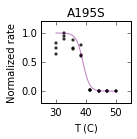

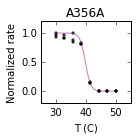

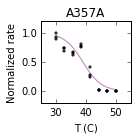

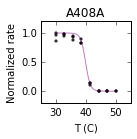

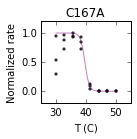

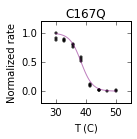

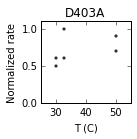

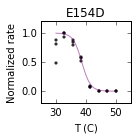

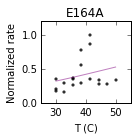

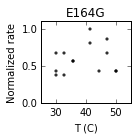

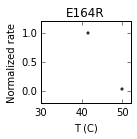

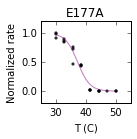

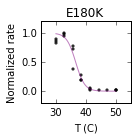

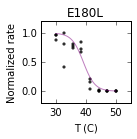

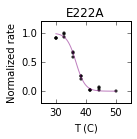

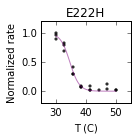

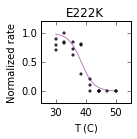

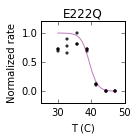

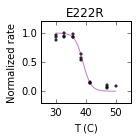

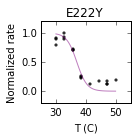

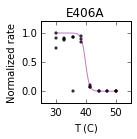

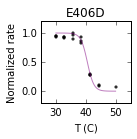

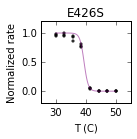

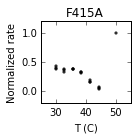

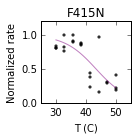

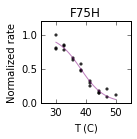

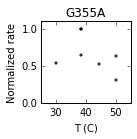

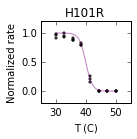

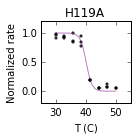

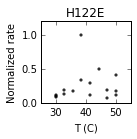

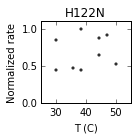

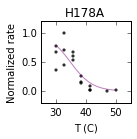

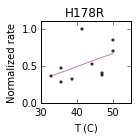

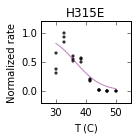

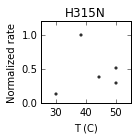

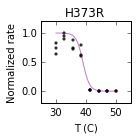

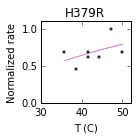

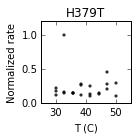

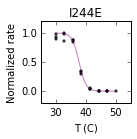

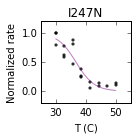

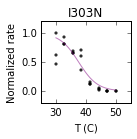

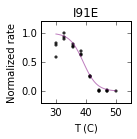

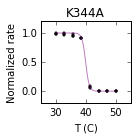

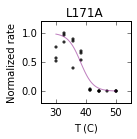

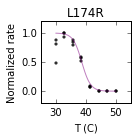

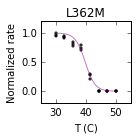

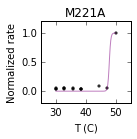

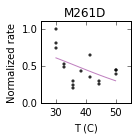

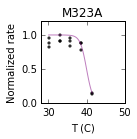

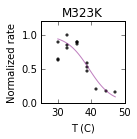

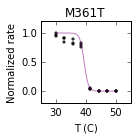

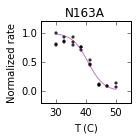

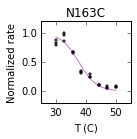

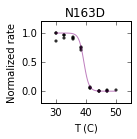

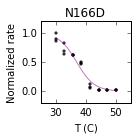

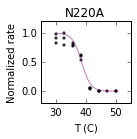

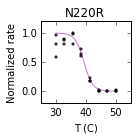

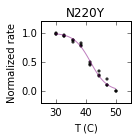

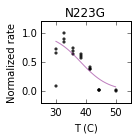

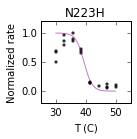

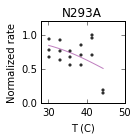

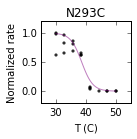

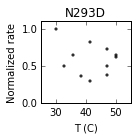

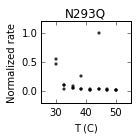

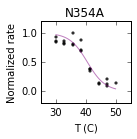

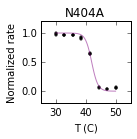

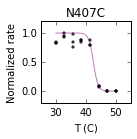

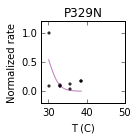

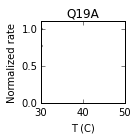

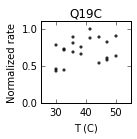

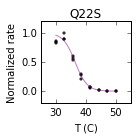

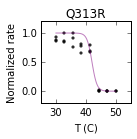

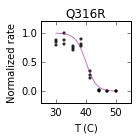

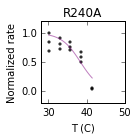

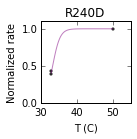

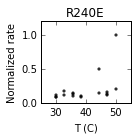

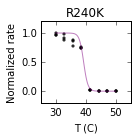

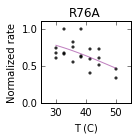

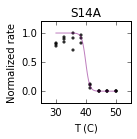

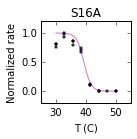

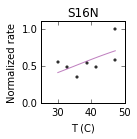

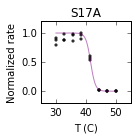

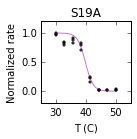

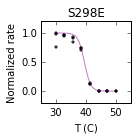

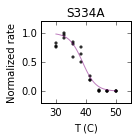

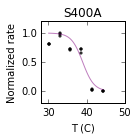

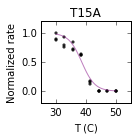

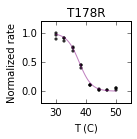

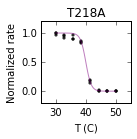

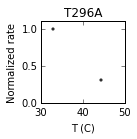

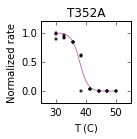

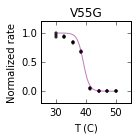

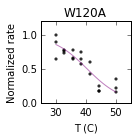

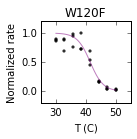

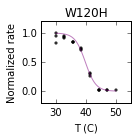

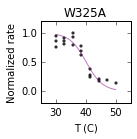

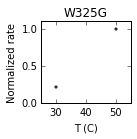

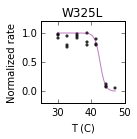

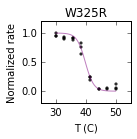

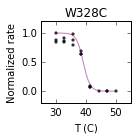

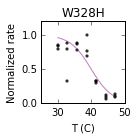

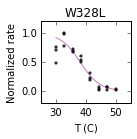

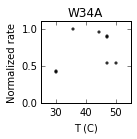

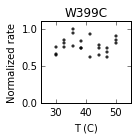

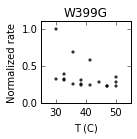

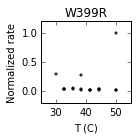

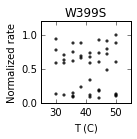

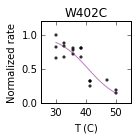

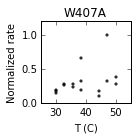

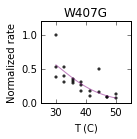

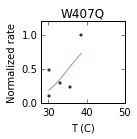

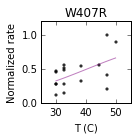

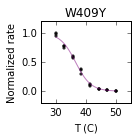

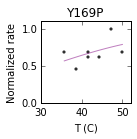

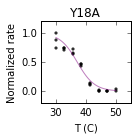

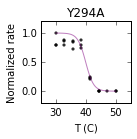

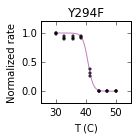

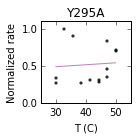

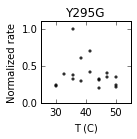

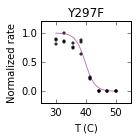

In [32]:
#!mkdir plots 
for index, df in grouped:
    name = df.mutant.unique()[0]
    rate = df.rate / df.rate.max() 
    plt.figure( figsize=(2,2) )
    plt.scatter( df.temp, rate, alpha=0.7, color='black', marker='.' )
    popt = fits.loc[ name ]
    if popt is not None:
        x_space = linspace( df.temp.min(), df.temp.max(), 100 )
        plt.plot( x_space, f( x_space, *popt ), alpha=0.5, color='purple' )
    plt.xlabel( 'T (C)' )
    plt.ylabel( 'Normalized rate')
    plt.xticks( [ 30, 40, 50 ] )
    plt.yticks( [ 0, 0.5, 1 ] )
    plt.title( name )
    plt.tight_layout()
    plt.savefig( 'plots/%s.pdf' % name, format='pdf' )
    plt.show()
    plt.close()

In [33]:
# add metadata
fits['native'] = fits.index.str[0]
fits['designed'] = fits.index.str[-1]
fits['position'] = fits.index.str[1:-1].astype( int )
fits.sample( 10 )

,tm,k,native,designed,position
mutant,,,,,
R240A,38.380776,-0.399698,R,A,240
F415A,NaN,NaN,F,A,415
H178A,34.903381,-0.272210,H,A,178
E222H,34.708312,-0.636223,E,H,222
A195S,39.082601,-0.906304,A,S,195
H178R,40.612793,0.072307,H,R,178
W407Q,35.197536,0.286612,W,Q,407
E154D,38.699104,-0.688686,E,D,154
A357A,39.094581,-0.325209,A,A,357


In [34]:
# makes resfiles for DDG Rosetta app 
#!mkdir ddg/resfiles 

for ( index, series ) in fits.iterrows():
    with open( 'ddg/resfiles/{}'.format( index ), 'w' ) as fn:
        fn.write( 'NATRO\nSTART\n{} A PIKAA {}'.format( series.position, series.designed ) )

In [35]:
%%bash 
# this will run the Rosetta app `ddg_monomer` on all the mutants in `fits`, above

#ls ddg/resfiles > ddg/list
#NUM=$( wc -l ddg/list | cut -d' ' -f1 )
#cd ddg && sbatch --array=1-${NUM} sub.sh 

## Comparison between Rosetta `ddg_monomer` app and experimental results

In [36]:
! ( head -1 ddg/ddg_predictions.out && grep -v desc ddg/ddg_predictions.out ) > ddg/readable_output

In [37]:
preds = pandas.read_csv( 'ddg/readable_output', sep='\s+' )
preds.index = preds.description.values
joined = preds.join( fits )
joined.sample( 10 )

,ddG:,description,total,fa_atr,fa_rep,fa_sol,fa_intra_rep,fa_elec,pro_close,hbond_sr_bb,...,fa_dun,p_aa_pp,ref,chainbreak,res_type_constraint,tm,k,native,designed,position
I91E,ddG:,I91E,2.410,-5.641,1.926,7.838,-0.016,-1.094,-0.025,0.099,...,3.039,0.182,-2.386,0,0,39.199525,-0.443905,I,E,91
H315N,ddG:,H315N,-0.746,-4.180,0.993,5.749,0.015,-2.032,-0.027,0.127,...,1.577,-0.099,-1.299,0,0,NaN,NaN,H,N,315
E164G,ddG:,E164G,-0.656,9.961,-0.390,-12.772,0.003,2.047,-0.034,0.173,...,-2.393,-0.609,1.694,0,0,NaN,NaN,E,G,164
S17A,ddG:,S17A,-3.074,3.016,-1.359,-2.921,0.017,-3.630,0.035,0.025,...,2.334,0.055,0.416,0,0,41.649042,-1.265546,S,A,17
P180K,ddG:,P180K,6.679,-2.316,0.221,5.030,0.020,1.490,-0.019,-0.053,...,2.256,0.470,-0.068,0,0,NaN,NaN,NaN,NaN,NaN
Y294A,ddG:,Y294A,6.140,14.237,-0.620,-5.127,-0.028,-0.701,-0.070,-0.105,...,-2.869,-0.014,0.461,0,0,39.999766,-0.755361,Y,A,294
H178R,ddG:,H178R,4.321,2.636,-0.100,1.583,0.101,1.701,0.009,0.103,...,-2.189,0.400,-0.507,0,0,40.612793,0.072307,H,R,178
M221A,ddG:,M221A,3.665,4.931,0.159,-1.178,-0.010,0.728,0.001,-0.474,...,-3.224,0.001,0.434,0,0,47.900321,3.990650,M,A,221
Q19A,ddG:,Q19A,1.286,7.382,-0.700,-5.518,-0.010,0.535,0.001,0.308,...,-2.886,-0.207,1.771,0,0,30.050000,0.000000,Q,A,19
W247N,ddG:,W247N,9.521,13.783,-1.416,-1.161,-0.020,-0.014,-0.015,0.037,...,-0.512,0.031,-1.871,0,0,NaN,NaN,NaN,NaN,NaN


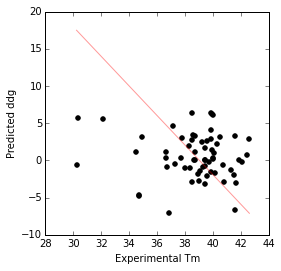

In [12]:
plt.figure( figsize=( 4, 4 ) )
plt.scatter( joined.tm, joined.total, color='k' )
plt.plot( ( joined.tm.min(), joined.tm.max() ), ( joined.total.max() , joined.total.min() ), color='red', alpha=0.4 ) #perfect correlation
plt.xlabel( 'Experimental Tm' )
plt.ylabel( 'Predicted ddg' )

total float64


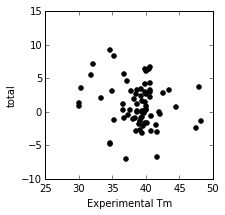

fa_atr float64


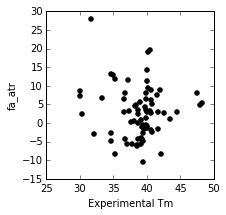

fa_rep float64


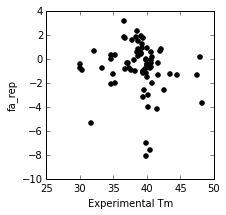

fa_sol float64


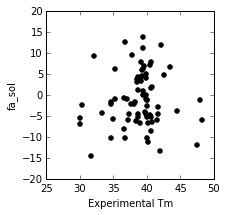

fa_intra_rep float64


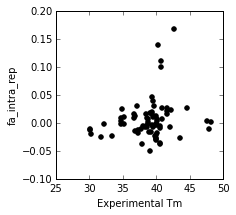

fa_elec float64


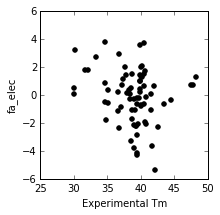

pro_close float64


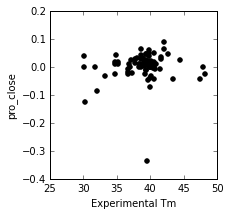

hbond_sr_bb float64


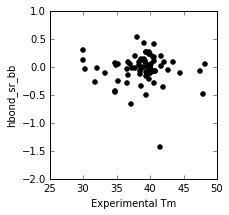

hbond_lr_bb float64


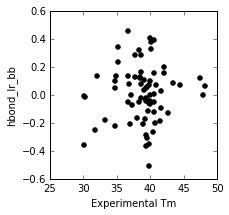

hbond_bb_sc float64


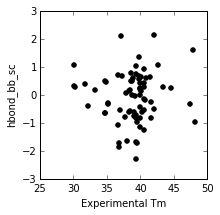

hbond_sc float64


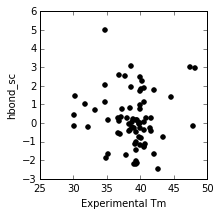

dslf_fa13 float64


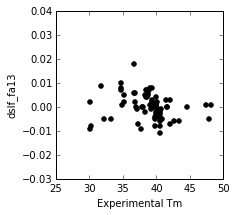

coordinate_constraint float64


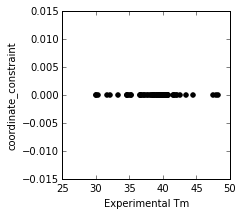

angle_constraint float64


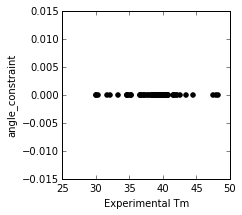

dihedral_constraint float64


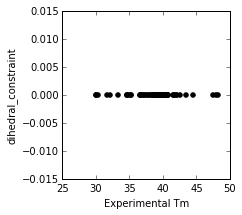

rama float64


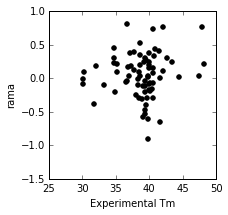

omega float64


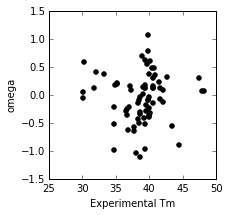

fa_dun float64


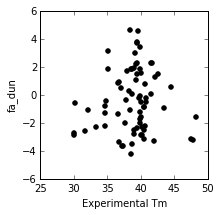

p_aa_pp float64


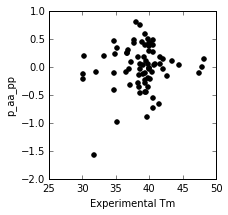

ref float64


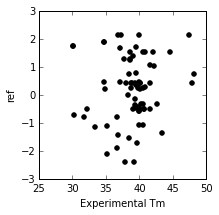

chainbreak float64


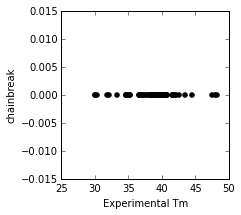

res_type_constraint float64


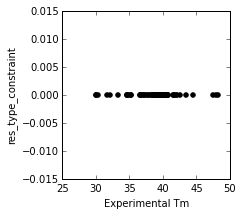

position float64


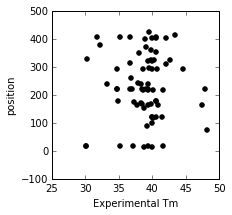

In [51]:
for col, dtype in zip( joined.columns, joined.dtypes ):
    if str( dtype ) == 'float64' and str( col ) not in ['tm', 'k']:
        print col, dtype
        plt.figure( figsize=( 3, 3 ) )
        plt.scatter( joined.tm, joined[col], color='k' )
        #plt.plot( ( joined.tm.min(), joined.tm.max() ), ( joined.total.max() , joined.total.min() ), color='red', alpha=0.4 ) #perfect correlation
        plt.xlabel( 'Experimental Tm' )
        plt.ylabel( col )
        plt.show()

So nothing really correlates, even predicted $\Delta G$ of folding. Bummmer. 

# Rosetta plus machine learning [outperforms `ddg_monomer`?]

Instead, let's make models of the mutants using `EnzRepackMinimize` and then try to use machine learning to get better correlation.

In [54]:
from sklearn.linear_model import ElasticNetCV
from sklearn.ensemble import BaggingRegressor
from sklearn.grid_search import GridSearchCV
from glob import glob 

dfs = [ pandas.read_csv( i, sep=r'\s+' ) for i in glob( 'enzdes/out/*sc' ) ]
df = pandas.concat( dfs )
print len( df ), 'models'

10896 models


In [ ]:
from Bio.SeqUtils import IUPACData
import screed

for record in screed.open( 'data/bglb.pep' ):
    seq = record.sequence

# get lowest 10% energy 
def low_10( df ):
    return df.sort( 'total_score' ).head( 10 )

# blarg, we have to reindex the DataFrame because of how I named the Rosetta output
l = []
for i in df.description:
    j = i.split( '_' )[1]
    pos = j[:-3]
    native = seq[ int(pos) - 1 ].upper()
    designed = IUPACData.protein_letters_3to1[ j[-3:].capitalize() ] # good god why
    l.append( '{}{}{}'.format( native, pos, designed ) )

df['name'] = l
df = df.groupby( 'name' ).apply( low_10 )

# reindex so we can join with experimental data 
assert len( l ) == len( df.index )
df.index = l 
joined = df.join( fits )
joined.sample( 100 )

print joined.columns
print len( joined )
joined.dropna( inplace = True )
print len( joined )

x_cols = [ u'total_score', u'fa_rep', u'hbond_sc', u'tot_pstat_pm',
       u'tot_nlpstat_pm', u'tot_burunsat_pm', u'tot_hbond_pm',
       u'tot_NLconts_pm', u'tot_nlsurfaceE_pm', u'tot_total_charge',
       u'tot_total_pos_charges', u'tot_total_neg_charges', u'tot_seq_recovery',
       u'SR_1_total_score', u'SR_1_fa_rep', u'SR_1_hbond_sc',
       u'SR_1_hbond_pm', u'SR_1_burunsat_pm',
       u'SR_1_pstat_pm', u'SR_1_nlpstat_pm', u'SR_2_total_score',
       u'SR_2_fa_rep', u'SR_2_hbond_sc', u'SR_2_all_cst', u'SR_2_hbond_pm',
       u'SR_2_burunsat_pm', u'SR_2_pstat_pm', u'SR_2_nlpstat_pm',
       u'SR_3_total_score', u'SR_3_fa_rep', u'SR_3_hbond_sc', 
       u'SR_3_hbond_pm', u'SR_3_burunsat_pm', u'SR_3_pstat_pm',
       u'SR_3_nlpstat_pm', u'SR_4_total_score', u'SR_4_fa_rep',
       u'SR_4_hbond_sc', u'SR_4_hbond_pm',
       u'SR_4_burunsat_pm', u'SR_4_pstat_pm', u'SR_4_nlpstat_pm',
       u'SR_5_total_score', u'SR_5_fa_rep', u'SR_5_hbond_sc', u'SR_5_all_cst',
       u'SR_5_interf_E_1_2', u'SR_5_dsasa_1_2', u'SR_5_hbond_pm',
       u'SR_5_burunsat_pm', ]

X = joined[ x_cols ]
y = joined[ 'tm' ]

plt.figure()

params = { 
    'l1_ratio': [ 0.001, 0.01, 0.1, 0.2, 0.5, 0.7, 0.9, 0.95, 0.99 ], 
    'cv': [ 10 ], 
}

grid = GridSearchCV( ElasticNetCV(), params )
bag = BaggingRegressor( grid, n_estimators=100 )
bag.fit( X, y )

preds = bag.predict( X )
plt.scatter( preds, y, alpha=0.3, marker='.' )
plt.xlabel( 'Predicted' )
plt.ylabel( 'Actual' )

from scipy.stats.stats import pearsonr

print 'PCC={}'.format( pearsonr( preds, y ) )

OK, so a PCC of 0.61 isn't *that* bad (it's still not great though). 